# Preprocessing

In [1]:
%run project_functions.ipynb

Using TensorFlow backend.


In [2]:
file_name = 'AAPL.json'
csv_name = 'AAPL.csv'

In [3]:
#Features
company = stock_twits_text_parser(file_name)
company_metrics = stock_twits_metrics(company, 3, file_name)

#Labels
company_return = return_over_period_T(csv_name,3)

#Cleaned Data
agg_data = feature_selector(company_metrics, company_return, 'close_return', 25, 1000)
company_data = split_data(agg_data, 0.7, 'all', 'close_return', 'cont')

#Split
X_train = company_data['X_train']
Y_train = company_data['Y_train']
X_test = company_data['X_test']
Y_test = company_data['Y_test']


# KNN Regression

In [4]:
# Find best model
model = get_best_knn_regressor(5, 30, 1, 5, X_train, Y_train)

# training and test predictions
pred_train_knn = model.predict(X_train)
pred_test_knn = model.predict(X_test)


Best Parameters: 
{'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}


# Action Signal Mapping

- 1 = Positive Action
- 0 = No Action
- -1 = Negative Action

In [5]:
as_train, as_test, as_predict_train, as_predict_test = action_signal_mapping(Y_train, Y_test, pred_train_knn, pred_test_knn, 0.0025)

# Classification Metrics

- Note: The cases detected as no action are not considered in these metrics

In [6]:
as_train_metrics, as_test_metrics, as_predict_train_metrics , as_predict_test_metrics = metrics_mapping_action_signals(as_train, as_test, as_predict_train, as_predict_test)





In [7]:
cm_action_signal_train = confusion_matrix(as_train_metrics,as_predict_train_metrics)
cm_action_signal_test = confusion_matrix(as_test_metrics,as_predict_test_metrics)

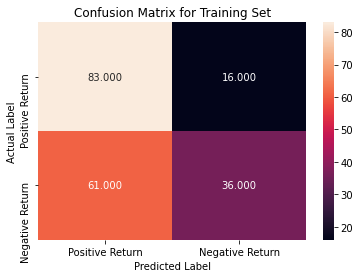

In [8]:
plot_confusion_matrix(cm_action_signal_train, "Training")

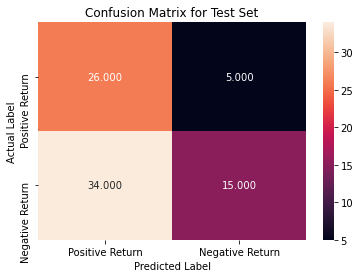

In [9]:
plot_confusion_matrix(cm_action_signal_test, "Test")

In [10]:
table = create_metrics_table(as_train_metrics, as_predict_train_metrics, as_test_metrics, as_predict_test_metrics)
table

,Recall,Precision,F1 Score,Accuracy
Dataset,,,,
Training,0.371134,0.692308,0.483221,0.607143
Test,0.306122,0.750000,0.434783,0.512500
